# Cancer Classifaction

In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# 1. Veri Yükleme
labels_df = pd.read_csv('../data/external/labels.csv')
data_df = pd.read_csv('../data/external/data.csv')

# Etiketlerdeki yazım hatasını düzeltme
labels_df['disease_type'] = labels_df['disease_type'].replace('prosrtate cancer', 'prostate cancer')

# İlk birkaç satırı inceleyelim
print("Labels veri seti:")
display(labels_df.head())
print("\nData veri seti:")
display(data_df.head())

Labels veri seti:


,Sample,disease_type
0,s12859,colon cancer
1,s12878,colon cancer
2,s12857,colon cancer
3,s12882,colon cancer
4,s12871,colon cancer



Data veri seti:


,Unnamed: 0,k__Viruses.f__Phycodnaviridae.g__Prasinovirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__Sfi1unalikevirus,k__Viruses.o__Herpesvirales.f__Herpesviridae.g__Simplexvirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__C2likevirus,k__Viruses.f__Poxviridae.g__Parapoxvirus,k__Viruses.f__Papillomaviridae.g__Dyolambdapapillomavirus,k__Viruses.o__Mononegavirales.f__Bornaviridae.g__Bornavirus,k__Viruses.f__Bicaudaviridae.g__Bicaudavirus,k__Viruses.o__Picornavirales.f__Picornaviridae.g__Aquamavirus,...,k__Bacteria.p__Synergistetes.c__Synergistia.o__Synergistales.f__Synergistaceae.g__Cloacibacillus,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Sellimonas,k__Archaea.p__Thaumarchaeota.g__Candidatus_Nitrosotenuis,k__Bacteria.p__Rhodothermaeota.c__Balneolia.o__Balneolales.f__Balneolaceae.g__Gracilimonas,k__Archaea.p__Crenarchaeota.c__Thermoprotei.o__Thermoproteales.f__Thermoproteaceae.g__Caldivirga,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Clostridiales_Family_XIII._Incertae_Sedis.g__Casaltella,k__Archaea.p__Crenarchaeota.c__Thermoprotei.o__Desulfurococcales.f__Desulfurococcaceae.g__Thermosphaera,k__Bacteria.p__Proteobacteria.c__Betaproteobacteria.o__Neisseriales.f__Chromobacteriaceae.g__Deefgea,k__Bacteria.p__Deferribacteres.c__Deferribacteres.o__Deferribacterales.f__Deferribacteraceae.g__Geovibrio,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Subdoligranulum
0,s12859,0,0,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,s12878,0,0,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,s12857,2,0,484,0,8,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
3,s12882,4,0,96,0,2,0,0,2,4,...,0,0,0,0,0,0,0,0,0,0
4,s12871,2,0,128,0,16,0,4,0,4,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# 2. Veri Hazırlama
if len(labels_df) == len(data_df):
    data_df['Sample'] = labels_df['Sample']
else:
    raise ValueError("labels.csv ve data.csv satır sayıları eşleşmiyor!")

# Etiketlerle verileri birleştirme
data_df = data_df.merge(labels_df, on='Sample')

# Birleştirilmiş veri setinin ilk birkaç satırını gösterelim
print("Birleştirilmiş veri seti:")
display(data_df.head())

Birleştirilmiş veri seti:


,Unnamed: 0,k__Viruses.f__Phycodnaviridae.g__Prasinovirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__Sfi1unalikevirus,k__Viruses.o__Herpesvirales.f__Herpesviridae.g__Simplexvirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__C2likevirus,k__Viruses.f__Poxviridae.g__Parapoxvirus,k__Viruses.f__Papillomaviridae.g__Dyolambdapapillomavirus,k__Viruses.o__Mononegavirales.f__Bornaviridae.g__Bornavirus,k__Viruses.f__Bicaudaviridae.g__Bicaudavirus,k__Viruses.o__Picornavirales.f__Picornaviridae.g__Aquamavirus,...,k__Archaea.p__Thaumarchaeota.g__Candidatus_Nitrosotenuis,k__Bacteria.p__Rhodothermaeota.c__Balneolia.o__Balneolales.f__Balneolaceae.g__Gracilimonas,k__Archaea.p__Crenarchaeota.c__Thermoprotei.o__Thermoproteales.f__Thermoproteaceae.g__Caldivirga,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Clostridiales_Family_XIII._Incertae_Sedis.g__Casaltella,k__Archaea.p__Crenarchaeota.c__Thermoprotei.o__Desulfurococcales.f__Desulfurococcaceae.g__Thermosphaera,k__Bacteria.p__Proteobacteria.c__Betaproteobacteria.o__Neisseriales.f__Chromobacteriaceae.g__Deefgea,k__Bacteria.p__Deferribacteres.c__Deferribacteres.o__Deferribacterales.f__Deferribacteraceae.g__Geovibrio,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Subdoligranulum,Sample,disease_type
0,s12859,0,0,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,s12859,colon cancer
1,s12878,0,0,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,s12878,colon cancer
2,s12857,2,0,484,0,8,0,0,2,2,...,0,0,0,0,0,0,0,0,s12857,colon cancer
3,s12882,4,0,96,0,2,0,0,2,4,...,0,0,0,0,0,0,0,0,s12882,colon cancer
4,s12871,2,0,128,0,16,0,4,0,4,...,0,0,0,0,0,0,0,0,s12871,colon cancer


In [25]:
# 3. Veri Temizleme ve Dönüştürme
feature_cols = [col for col in data_df.columns if col not in ['Sample', 'disease_type']]
for col in feature_cols:
    data_df[col] = pd.to_numeric(data_df[col], errors='coerce')

# NaN değerleri kontrol etme ve doldurma
data_df[feature_cols] = data_df[feature_cols].fillna(0)

In [26]:
# 4. Veri Normalleştirme
data_df[feature_cols] = data_df[feature_cols].div(data_df[feature_cols].sum(axis=1), axis=0)
data_df[feature_cols] = data_df[feature_cols].fillna(0)

In [27]:
# 5. Yardımcı Fonksiyonlar
def prepare_data(cancer_type):
    y = (data_df['disease_type'] == cancer_type).astype(int)
    X = data_df[feature_cols]
    return X, y

def compute_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return sensitivity, specificity, accuracy, f1

In [28]:
# 6. Model Oluşturma ve Eğitim
cancer_types = ['lung cancer', 'prostate cancer', 'colon cancer', 'breast cancer']
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []

In [29]:
# 6. Model Oluşturma ve Eğitim
cancer_types = ['lung cancer', 'prostate cancer', 'colon cancer', 'breast cancer']
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []

In [30]:
# 7. Parametre Optimizasyonu (GridSearchCV ve RandomizedSearchCV)
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 10]
}

In [31]:
# 8. Çapraz Doğrulama ve Parametre Arama
for cancer in cancer_types:
    print(f"\n{cancer} için sınıflandırma")
    X, y = prepare_data(cancer)
    
    # Veri seti dengesi kontrol etme
    print(f"Pozitif örnekler: {sum(y)}, Negatif örnekler: {len(y) - sum(y)}")
    
    # Veriyi bölme
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Eğitim seti boyutu: {len(X_train)}, Test seti boyutu: {len(X_test)}")

    # Stratified KFold için
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for model_name, model in models.items():
        print(f"\n{model_name} modeli eğitiliyor...")

        if model_name == 'Random Forest':
            # RandomizedSearchCV kullanma (daha hızlı sonuç için)
            grid_search = RandomizedSearchCV(model, rf_param_grid, n_iter=10, cv=kfold, random_state=42, n_jobs=-1)
        elif model_name == 'XGBoost':
            grid_search = RandomizedSearchCV(model, xgb_param_grid, n_iter=10, cv=kfold, random_state=42, n_jobs=-1)

        # Modeli eğitme
        grid_search.fit(X_train, y_train)

        # En iyi parametreleri yazdırma
        print(f"{model_name} için en iyi parametreler: {grid_search.best_params_}")

        # En iyi model ile test verisini tahmin etme
        y_pred = grid_search.best_estimator_.predict(X_test)

        # Metrikleri hesaplama
        sensitivity, specificity, accuracy, f1 = compute_metrics(y_test, y_pred)
        
        print(f"{model_name} - Duyarlılık: {sensitivity:.4f}, Özgüllük: {specificity:.4f}, Doğruluk: {accuracy:.4f}, F1 Skoru: {f1:.4f}")
        
        results.append({
            'Kanser Türü': cancer,
            'Model': model_name,
            'Duyarlılık': sensitivity,
            'Özgüllük': specificity,
            'Doğruluk': accuracy,
            'F1 Skoru': f1
        })



lung cancer için sınıflandırma
Pozitif örnekler: 18, Negatif örnekler: 337
Eğitim seti boyutu: 284, Test seti boyutu: 71

Random Forest modeli eğitiliyor...
Random Forest için en iyi parametreler: {'n_estimators': 150, 'min_samples_split': 2, 'max_depth': 20}
Random Forest - Duyarlılık: 1.0000, Özgüllük: 1.0000, Doğruluk: 1.0000, F1 Skoru: 1.0000

XGBoost modeli eğitiliyor...


C:\Users\athlb\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [13:37:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost için en iyi parametreler: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}
XGBoost - Duyarlılık: 1.0000, Özgüllük: 1.0000, Doğruluk: 1.0000, F1 Skoru: 1.0000

prostate cancer için sınıflandırma
Pozitif örnekler: 121, Negatif örnekler: 234
Eğitim seti boyutu: 284, Test seti boyutu: 71

Random Forest modeli eğitiliyor...
Random Forest için en iyi parametreler: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 30}
Random Forest - Duyarlılık: 1.0000, Özgüllük: 0.9565, Doğruluk: 0.9718, F1 Skoru: 0.9615

XGBoost modeli eğitiliyor...


C:\Users\athlb\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [13:37:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost için en iyi parametreler: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1}
XGBoost - Duyarlılık: 0.9600, Özgüllük: 1.0000, Doğruluk: 0.9859, F1 Skoru: 0.9796

colon cancer için sınıflandırma
Pozitif örnekler: 109, Negatif örnekler: 246
Eğitim seti boyutu: 284, Test seti boyutu: 71

Random Forest modeli eğitiliyor...
Random Forest için en iyi parametreler: {'n_estimators': 150, 'min_samples_split': 2, 'max_depth': 20}
Random Forest - Duyarlılık: 0.8462, Özgüllük: 1.0000, Doğruluk: 0.9437, F1 Skoru: 0.9167

XGBoost modeli eğitiliyor...


C:\Users\athlb\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [13:38:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost için en iyi parametreler: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}
XGBoost - Duyarlılık: 0.9231, Özgüllük: 0.9778, Doğruluk: 0.9577, F1 Skoru: 0.9412

breast cancer için sınıflandırma
Pozitif örnekler: 107, Negatif örnekler: 248
Eğitim seti boyutu: 284, Test seti boyutu: 71

Random Forest modeli eğitiliyor...
Random Forest için en iyi parametreler: {'n_estimators': 50, 'min_samples_split': 10, 'max_depth': 30}
Random Forest - Duyarlılık: 0.7222, Özgüllük: 1.0000, Doğruluk: 0.9296, F1 Skoru: 0.8387

XGBoost modeli eğitiliyor...


C:\Users\athlb\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [13:38:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost için en iyi parametreler: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}
XGBoost - Duyarlılık: 0.8889, Özgüllük: 1.0000, Doğruluk: 0.9718, F1 Skoru: 0.9412


,Kanser Türü,Model,Duyarlılık,Özgüllük,Doğruluk,F1 Skoru
0,lung cancer,Random Forest,1.000000,1.000000,1.000000,1.000000
1,lung cancer,XGBoost,1.000000,1.000000,1.000000,1.000000
2,prostate cancer,Random Forest,1.000000,0.956522,0.971831,0.961538
3,prostate cancer,XGBoost,0.960000,1.000000,0.985915,0.979592
4,colon cancer,Random Forest,0.846154,1.000000,0.943662,0.916667
5,colon cancer,XGBoost,0.923077,0.977778,0.957746,0.941176
6,breast cancer,Random Forest,0.722222,1.000000,0.929577,0.838710
7,breast cancer,XGBoost,0.888889,1.000000,0.971831,0.941176


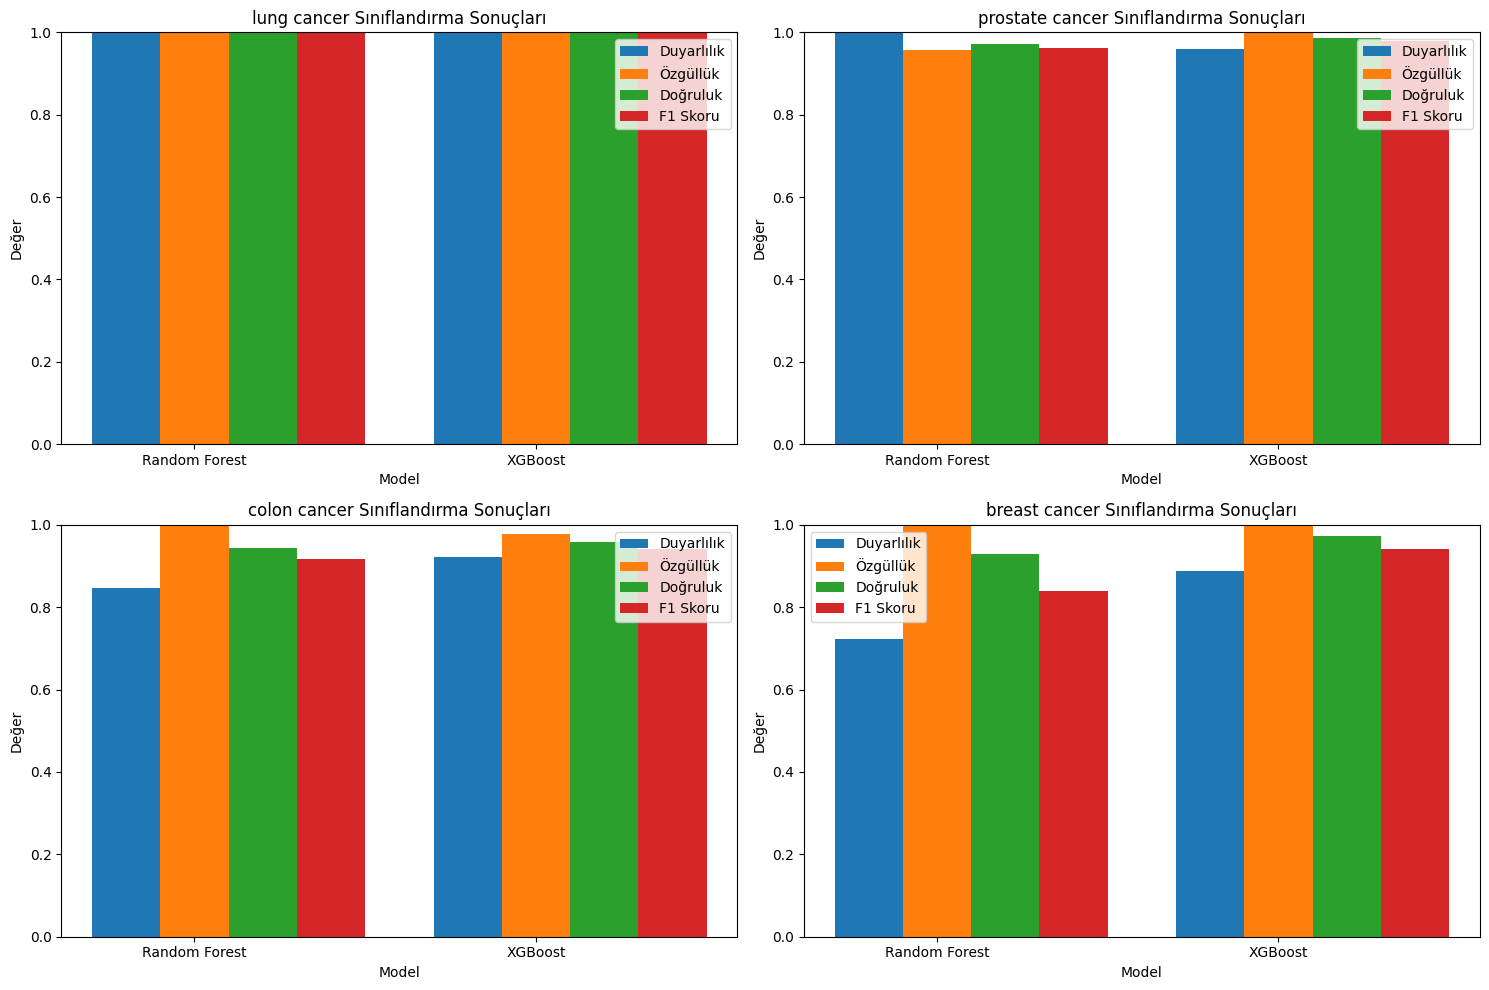

In [32]:
# 9. Sonuçları Kaydetme ve Görselleştirme
results_df = pd.DataFrame(results)
display(results_df)

# Sonuçları görselleştirme
plt.figure(figsize=(15, 10))
for i, cancer in enumerate(cancer_types):
    plt.subplot(2, 2, i+1)
    cancer_results = results_df[results_df['Kanser Türü'] == cancer]
    
    x = range(len(cancer_results))
    width = 0.2

    plt.bar([p - width for p in x], cancer_results['Duyarlılık'], width, label='Duyarlılık')
    plt.bar([p for p in x], cancer_results['Özgüllük'], width, label='Özgüllük')
    plt.bar([p + width for p in x], cancer_results['Doğruluk'], width, label='Doğruluk')
    plt.bar([p + 2 * width for p in x], cancer_results['F1 Skoru'], width, label='F1 Skoru')

    plt.xlabel('Model')
    plt.ylabel('Değer')
    plt.title(f'{cancer} Sınıflandırma Sonuçları')
    plt.xticks(x, cancer_results['Model'])
    plt.ylim(0, 1.0)
    plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# Sonuçları CSV dosyasına kaydetme
import os
file_path = '../data/processed/classification_results.csv'
if os.path.exists(file_path):
    results_df.to_csv(file_path, index=False)
    print(f"\n'{file_path}' dosyasının üzerine yazıldı.")
else:
    results_df.to_csv(file_path, index=False)
    print(f"\n'{file_path}' dosyası oluşturuldu ve sonuçlar kaydedildi.")


'../data/processed/classification_results.csv' dosyasının üzerine yazıldı.
